make sure to setup packages first

setup sims_photUtils -t sims

setup sims_catUtils -t sims

setup sims_sed_library -t sims

In [1]:
import os
import numpy as np

from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.Bandpass import Bandpass
%matplotlib inline
import matplotlib.pylab as plt

In [2]:
import os
import numpy as np

from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.Bandpass import Bandpass

In [3]:
# See? Weird, right?

In [4]:
# and if you try copypasting in the code from get_star_properties.py:

In [5]:
from lsst.utils import getPackageDir
from lsst.sims.catUtils.baseCatalogModels import StarObj
from lsst.sims.utils import ObservationMetaData
from lsst.sims.utils import equatorialFromGalactic

/Users/yoachim/gitRepos/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:553: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/yoachim/gitRepos/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:553: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


In [6]:
# And that one doesn't go anywhere if you try running the cell again.

In [7]:
# And if you try getting around that by skipping that line, I get this error instead. I've looked, and
# lsst.sims.catUtils really doesn't seem to be on my computer anywhere.

In [8]:
from lsst.sims.catUtils.baseCatalogModels import StarObj
from lsst.sims.utils import ObservationMetaData
from lsst.sims.utils import equatorialFromGalactic

In [9]:
import os
import numpy as np

from lsst.utils import getPackageDir
from lsst.sims.catUtils.baseCatalogModels import StarObj
from lsst.sims.utils import ObservationMetaData
from lsst.sims.utils import equatorialFromGalactic

def get_kurucz_phys(sed_name_in):
    """
    Read in the name of a kurucz SED file.  Return it's
    T_eff, metallicity, log(surface gravity)
    """
    sed_name = sed_name_in.replace('.gz','')
    if sed_name[1] == 'p':
        metallicity_sgn = 1.0
    elif sed_name[1] == 'm':
        metallicity_sgn = -1.0
    else:
        raise RuntimeError('Cannot parse metallicity sign of %s' % sed_name)

    new_name = sed_name.replace('.','_').split('_')

    metallicity = 0.1*metallicity_sgn*float(new_name[0][2:])

    teff = float(new_name[-1])

    logg = 0.1*np.float(new_name[3][1:])

    return teff, metallicity, logg


def get_wd_phys(sed_name):
    """
    Read in the name of a white dwarf SED,
    return its T_eff, metallicity (which we don't actually have),
    and log(surface gravity)
    """
    new_name = sed_name.replace('.','_').split('_')
    if new_name[1]!='He':
        logg = 0.1*float(new_name[2])
        teff = float(new_name[4])
    else:
        logg = 0.1*float(new_name[3])
        teff = float(new_name[5])


    return teff, -999.0, logg


def get_mlt_phys(sed_name):
    """
    Read in the name of an M/L/T dwarf SED and return
    its T_eff, metallicity, and log(surface gravity)
    """

    new_name = sed_name.replace('+','-').replace('a','-').split('-')

    logg_sgn_dex = len(new_name[0])

    if sed_name[logg_sgn_dex] == '-':
        logg_sgn = 1.0
    elif sed_name[logg_sgn_dex] == '+':
        logg_sgn = -1.0
    else:
        raise RuntimeError('Cannot get logg_sgn for %s' % sed_name)

    metallicity_sgn_dex = len(new_name[0]) + len(new_name[1]) + 1

    if sed_name[metallicity_sgn_dex] == '-':
        metallicity_sgn = -1.0
    elif sed_name[metallicity_sgn_dex] == '+':
        metallicity_sgn = 1.0
    else:
        raise RuntimeError('Cannot get metallicity_sgn for %s' % sed_name)

    teff = 100.0*float(new_name[0][3:])
    metallicity = metallicity_sgn*float(new_name[2])
    logg = logg_sgn*float(new_name[1])

    return teff, metallicity, logg


def get_physical_characteristics(sed_name):
    """
    Read in the name of an SED file.
    Return (in this order) Teff, metallicity (FeH), log(g)
    """
    sed_name = sed_name.strip()

    if not hasattr(get_physical_characteristics, 'teff_dict'):
        get_physical_characteristics.teff_dict = {}
        get_physical_characteristics.logg_dict = {}
        get_physical_characteristics.metal_dict = {}

    if sed_name in get_physical_characteristics.teff_dict:
        return (get_physical_characteristics.teff_dict[sed_name],
                get_physical_characteristics.metal_dict[sed_name],
                get_physical_characteristics.logg_dict[sed_name])

    if sed_name.startswith('bergeron'):
        sub_dir = 'wDs'
    elif sed_name.startswith('lte'):
        sub_dir = 'mlt'
    elif sed_name[0] == 'k':
        sub_dir = 'kurucz'
    else:
        raise RuntimeError("Do not understand name %s" % sed_name)

    

    if 'kurucz' in sub_dir:
        tt,mm,gg =  get_kurucz_phys(sed_name)
    elif sub_dir == 'wDs':
        tt,mm,gg = get_wd_phys(sed_name)
    elif sub_dir == 'mlt':
        tt,mm,gg = get_mlt_phys(sed_name)
    else:
        raise RuntimeError('Do not know how to get '
                           'physical characteristics for '
                           'sub_dir %s' % sub_dir)

    get_physical_characteristics.teff_dict[sed_name] = tt
    get_physical_characteristics.metal_dict[sed_name] = mm
    get_physical_characteristics.logg_dict[sed_name] = gg

    return tt, mm, gg


In [10]:
# OK. let's grab some stars and save for later. Copy stuff from Scott's get_star_properties.py script

# find the RA, Dec of the north Galactic pole
ra, dec = equatorialFromGalactic(0.0, 90.0)

# Hmm, that ra, dec didn't seem to work for me, let's just point here for now
ra = 100.
dec = -40.


# define a field of view that is a circle of radius 1 degree
# around that point
obs = ObservationMetaData(pointingRA=ra, pointingDec=dec,
                          boundType='circle',
                          boundLength=1.0)

# connect to our database of simulated stars
# (if you want to do this from off campus, talk to me;
# there are more authentication steps you need to go through)
star_db = StarObj(database='LSSTCATSIM',
                  host='fatboy.phys.washington.edu',
                  port=1433, driver='mssql+pymssql')

# define the columns you want to get from the database
# (note: the query automatically adds the 'simobjid'
# column to the front; that is just an integer
# uniquely identifying each star)
column_names = ['ra', 'decl', 'sedFilename', 'rmag', 'gmag', 'imag']

results = star_db.query_columns(colnames=column_names,
                                obs_metadata=obs)

# results is now an iterator over chunks of stars
# to get numpy arrays of teff, metallicity, logg, and rmag
# use
teff = []
metallicity = []
logg = []
rmag = []
gmag = []
imag = []
for chunk in results:
    for line in chunk:
        phys_params = get_physical_characteristics(line['sedFilename'])
        if phys_params is not None:
            teff.append(phys_params[0])
            metallicity.append(phys_params[1])
            logg.append(phys_params[2])
            rmag.append(line['rmag'])
            gmag.append(line['gmag'])
            imag.append(line['imag'])

teff = np.array(teff)
metallicity = np.array(metallicity)
logg = np.array(logg)
rmag = np.array(rmag)
imag = np.array(imag)
gmag = np.array(gmag)


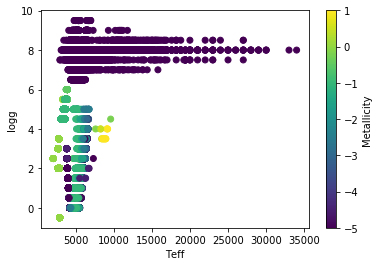

In [11]:
# plot up and see that we got some data
plt.scatter(teff, logg, c=metallicity, vmin=-5)
cb = plt.colorbar()
plt.xlabel('Teff')
plt.ylabel('logg')
cb.set_label('Metallicity')

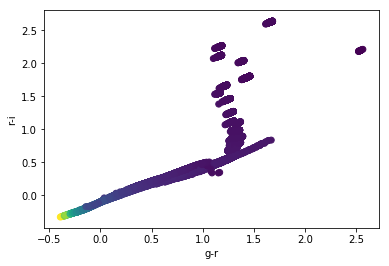

In [12]:
plt.scatter(gmag-rmag, rmag-imag, c=teff)
plt.xlabel('g-r')
plt.ylabel('r-i')

In [13]:
# Let's dump everything into one big array to keep track of it
names = ['teff', 'metallicity', 'logg', 'gmag', 'rmag', 'imag']
dtypes = [float]*6
from_catsim = np.empty(imag.size, dtype=list(zip(names,dtypes)))

# ugh, I'm too lazy to do this a better way
from_catsim['teff'] = teff
from_catsim['metallicity'] = metallicity
from_catsim['logg'] = logg
from_catsim['gmag'] = gmag
from_catsim['rmag'] = rmag
from_catsim['imag'] = imag

In [14]:
np.savez('stars_from_catsim.npz', from_catsim=from_catsim)

In [15]:
# To load back up
temp = np.load('stars_from_catsim.npz')
# Have to copy to get it into memory, otherwise it reads off disk every time
data_back = temp['from_catsim'].copy()
temp.close()

In [16]:
data_back

array([( 3500., -1.,  4.5,  29.15061  ,  27.86252  ,  26.88286  ),
       ( 2700., -0.,  2. ,  27.6896   ,  26.25251  ,  24.4602   ),
       ( 3400., -1.,  4.5,  22.9489   ,  21.66766  ,  20.55609  ), ...,
       ( 8950.,  1.,  3.5,  13.386506 ,  13.4968833,  13.6648923),
       ( 9200.,  1.,  4. ,  19.0695859,  19.1674051,  19.3290885),
       ( 8540.,  1.,  3.5,  14.2749375,  14.329094 ,  14.4727031)],
      dtype=[('teff', '<f8'), ('metallicity', '<f8'), ('logg', '<f8'), ('gmag', '<f8'), ('rmag', '<f8'), ('imag', '<f8')])

In [17]:
data_back.size

127426